## UGCA Group Assignment 4

# Group Members
1. Chetna Singhal
2. David Kinman
3. Prajval Gupta
4. Subhayu Chakravarty
5. Whitt Hyde

In [87]:
from selenium import webdriver
from bs4 import BeautifulSoup as bs
import time
import re
from urllib.request import urlopen
import json
import pandas as pd, numpy as np
from pandas.io.json import json_normalize

import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
import ast
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

In [3]:
### Scraping Instagram for urls, likes, and  via Selenium ###
username='manofthekinfolk'
account='natgeo'
browser = webdriver.Chrome(executable_path='C:\\Users\\david\\Downloads\\chromedriver\\chromedriver.exe')
browser.get('https://www.instagram.com/'+account+'/?hl=en')
Pagelength = browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")

# Data Collection

In [29]:
number_of_images = 10000
browser = webdriver.Chrome(executable_path='C:\\Users\\david\\Downloads\\chromedriver\\chromedriver.exe')
browser.get('https://www.instagram.com/'+account+'/?hl=en')
last_height = browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
links=[]
while len(links) < number_of_images:
    source = browser.page_source
    data=bs(source, 'html.parser')
    body = data.find('body')
    script = body.find('span')
    for link in script.findAll('a'):
         if re.match("/p", link.get('href')):
            pre_link = links.append('https://www.instagram.com'+link.get('href'))
            if pre_link not in links:
                links.append(pre_link)
    while True:
        browser.execute_script("window.scrollTo(0, document.body.scrollHeight/4.0);")
        time.sleep(5)
        new_height = browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        if last_height == new_height:
            break
        last_height = new_height
#     return links

In [30]:
len(links)

10021

In [31]:
result=pd.DataFrame()
for i in range(len(links)):
    try:
        page = urlopen(links[i]).read()
        data=bs(page, 'html.parser')
        body = data.find('body')
        script = body.find('script')
        raw = script.text.strip().replace('window._sharedData =', '').replace(';', '')
        json_data=json.loads(raw)
        posts =json_data['entry_data']['PostPage'][0]['graphql']
        posts= json.dumps(posts)
        posts = json.loads(posts)
        x = pd.DataFrame.from_dict(json_normalize(posts), orient='columns') 
        x.columns =  x.columns.str.replace("shortcode_media.", "")
        result=result.append(x)
       
    except:
        np.nan
#Just check for the duplicates
result = result.drop_duplicates(subset = 'shortcode')
result.index = range(len(result.index))

In [32]:
result2 = pd.concat([result.loc[:,'display_url'],result.loc[:,'edge_media_to_caption.edges'],result.loc[:,'edge_media_to_parent_comment.count'],result.loc[:,'edge_media_preview_like.count']], axis='columns')
result2 = result2.rename(columns={"display_url":"URL","edge_media_to_caption.edges":"UnfinishedCaption","edge_media_to_parent_comment.count":"Comment Count","edge_media_preview_like.count":"Like Count"})
result2['UnfinishedCaption']=result2['UnfinishedCaption'].astype(str)
result2.loc[:, 'Caption'] = result2.UnfinishedCaption.map(lambda x: x[20:-4])
result2 = pd.concat([result2.loc[:,'URL'],result2.loc[:,'Caption'],result2.loc[:,'Like Count'],result2.loc[:,'Comment Count']], axis='columns')
word = 'Video'   
result3 = result2[~result2["Caption"].str.contains(word, na=False)]
word = 'Photos'
result4 = result3[~result3["Caption"].str.contains(word, na=False)]
result4

,URL,Caption,Like Count,Comment Count
1,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @brianskerry | The U.S. Civil War sub...,84699,268
3,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by William Albert Allard @williamalberta...,168260,519
4,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by David Guttenfelder @dguttenfelder | T...,252696,491
6,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by Nichole Sobecki @nicholesobecki | Omm...,114367,297
7,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @lucasfogliaphoto | Ashley Klein does...,287042,1717
...,...,...,...,...
1087,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by Diana Markosian @markosian | A mother...,248822,604
1092,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by Keith Ladzinski @ladzinski | An engin...,229292,652
1093,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by Michael Yamashita @yamashitaphoto | A...,558047,1748
1095,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by Joel Sartore @joelsartore | This red-...,442934,1451


In [33]:
export_csv = result4.to_csv (r'C:\Users\david\Pictures\UGCA\Final\Instagram_dataframe.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path

unedited_csv=result.to_csv (r'C:\Users\david\Pictures\UGCA\Final\Unedited_Instagram_dataframe.csv', index = None, header=True)

In [36]:
result4.index = range(len(result4.index))
result4

,URL,Caption,Like Count,Comment Count
0,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @brianskerry | The U.S. Civil War sub...,84699,268
1,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by William Albert Allard @williamalberta...,168260,519
2,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by David Guttenfelder @dguttenfelder | T...,252696,491
3,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by Nichole Sobecki @nicholesobecki | Omm...,114367,297
4,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @lucasfogliaphoto | Ashley Klein does...,287042,1717
...,...,...,...,...
952,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by Diana Markosian @markosian | A mother...,248822,604
953,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by Keith Ladzinski @ladzinski | An engin...,229292,652
954,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by Michael Yamashita @yamashitaphoto | A...,558047,1748
955,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by Joel Sartore @joelsartore | This red-...,442934,1451


### Importing data from csv to Dataframe

In [5]:
full = pd.read_csv(r'Instagram_dataframe.csv')

### Test data set 

In [6]:
full = pd.concat([full.loc[0:2,:],full.loc[4:188,:],full.loc[275:340,:],full.loc[341:381,:],full.loc[383:558,:],full.loc[560:672,:],full.loc[674:695,:],full.loc[697:705,:],full.loc[707:774,:],full.loc[776:870,:],full.loc[872:945,:],full.loc[947:,:]])
full.index = range(len(full.index))
full

,URL,Caption,Like Count,Comment Count
0,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @brianskerry | The U.S. Civil War sub...,84699,268
1,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by William Albert Allard @williamalberta...,168260,519
2,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by David Guttenfelder @dguttenfelder | T...,252696,491
3,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @lucasfogliaphoto | Ashley Klein does...,287042,1717
4,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @gerdludwig | Known for their elabora...,149658,394
...,...,...,...,...
857,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by Diana Markosian @markosian | A mother...,248822,604
858,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by Keith Ladzinski @ladzinski | An engin...,229292,652
859,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by Michael Yamashita @yamashitaphoto | A...,558047,1748
860,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by Joel Sartore @joelsartore | This red-...,442934,1451


### Actual Dataset 

In [7]:
api_df = full.loc[0:538,:]
api_df = pd.concat([full.loc[0:6,:],full.loc[12:186,:],full.loc[193:250,:],full.loc[254:290,:],full.loc[295:466,:],full.loc[491:541,:]])
api_df

,URL,Caption,Like Count,Comment Count
0,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @brianskerry | The U.S. Civil War sub...,84699,268
1,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by William Albert Allard @williamalberta...,168260,519
2,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by David Guttenfelder @dguttenfelder | T...,252696,491
3,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @lucasfogliaphoto | Ashley Klein does...,287042,1717
4,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @gerdludwig | Known for their elabora...,149658,394
...,...,...,...,...
537,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by Ira Block @irablockphoto | A red-tail...,454383,1601
538,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by Nora Lorek @noralorek | Three years a...,122497,377
539,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,"Photo by Ami Vitale @amivitale | On Monday, @U...",493142,2411
540,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by Paolo Woods and Gabriele Galimberti ...,331186,2307


In [8]:
_csv=api_df.to_csv (r'Posts.csv', index = None, header=True)

# Google Vision API


In [22]:
list_of_urls = api_df["URL"].tolist() #change test to api_df when ready

In [23]:
from google.cloud import vision
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "keyFile.json"
image_urls = list_of_urls
ls_of_label_for_url = []

for url in image_urls:
    image_uri = url
    label_list = []
    client = vision.ImageAnnotatorClient()
    image = vision.types.Image()
    image.source.image_uri = image_uri
    response = client.label_detection(image=image)
    print('Labels (and confidence score):')
    print('=' * 79)
    
    for label in response.label_annotations:
        label_list.append(label.description)
        print(f'{label.description} ({label.score*100.:.2f}%)')
    ls_of_label_for_url.append(label_list)
    
print(ls_of_label_for_url)
print('Length of unedited list',len(ls_of_label_for_url))

ls_of_label_for_url = list(filter(None, ls_of_label_for_url))
print(ls_of_label_for_url)
print('Length of edited list', len(ls_of_label_for_url))

Labels (and confidence score):
Rays and skates (88.14%)
Fish (82.69%)
Underwater (81.39%)
Water (80.73%)
Manta ray (77.54%)
Organism (76.72%)
Marine biology (73.21%)
Stingray (71.06%)
Cartilaginous fish (61.89%)
Skate (60.42%)
Labels (and confidence score):
Photography (62.42%)
Labels (and confidence score):
Badlands (98.23%)
Mountainous landforms (98.08%)
Sky (97.49%)
Nature (95.35%)
Mountain (93.90%)
Rock (93.53%)
Formation (91.75%)
Cloud (91.28%)
Wilderness (89.94%)
Geology (88.88%)
Labels (and confidence score):
Rock (69.81%)
Tourism (69.71%)
Landscape (59.31%)
National park (54.88%)
Labels (and confidence score):
People (95.68%)
Community (84.84%)
Yellow (83.63%)
Tradition (76.61%)
Event (76.34%)
Temple (72.84%)
Tourism (68.09%)
Adaptation (66.97%)
Sari (66.58%)
Smile (64.11%)
Labels (and confidence score):
Water (95.78%)
Photograph (95.59%)
Sky (94.83%)
Sea (93.78%)
Skin (90.60%)
Beauty (90.38%)
Ocean (87.65%)
Vacation (86.62%)
Summer (83.16%)
Cloud (80.34%)
Labels (and confidenc

Labels (and confidence score):
Sky (97.45%)
Water (95.13%)
Blue (92.70%)
Sea (85.70%)
Atmosphere (84.04%)
Cloud (83.81%)
Ocean (83.12%)
Horizon (70.93%)
Rock (69.81%)
Tree (68.69%)
Labels (and confidence score):
Sky (99.05%)
Cloud (98.27%)
White (97.18%)
Black (97.01%)
Black-and-white (95.77%)
Nature (95.50%)
Monochrome photography (95.11%)
Monochrome (93.93%)
Water (91.00%)
Natural landscape (88.55%)
Labels (and confidence score):
Yellow (86.49%)
Sky (82.21%)
Sand (73.38%)
Dune (66.73%)
Landscape (65.04%)
Heat (51.50%)
Aeolian landform (51.19%)
Labels (and confidence score):
Design (72.03%)
Room (71.39%)
Photography (70.60%)
Material property (69.92%)
Technology (67.58%)
Architecture (65.45%)
Black-and-white (56.41%)
Collage (55.30%)
Interior design (54.31%)
Art (50.22%)
Labels (and confidence score):
Room (82.12%)
Photography (62.42%)
Sitting (60.23%)
Labels (and confidence score):
Art (50.22%)
Labels (and confidence score):
People (95.89%)
Green (94.52%)
Product (93.48%)
Social grou

Labels (and confidence score):
Wildlife (97.06%)
Hyena (90.16%)
Grassland (88.67%)
Natural landscape (88.55%)
Savanna (88.54%)
Spotted hyena (88.37%)
Safari (84.21%)
Plain (78.23%)
Lion (77.64%)
Ecoregion (75.62%)
Labels (and confidence score):
Snow (96.48%)
Winter (95.78%)
Bridge (91.46%)
Trestle (84.69%)
Freezing (83.59%)
Water (80.73%)
Wood (69.17%)
Landscape (65.04%)
Pier (64.72%)
Mountain (54.44%)
Labels (and confidence score):
Blue (98.02%)
Sky (95.85%)
Eyewear (88.57%)
House (85.83%)
Glasses (84.64%)
Fun (82.20%)
Winter (82.14%)
Cloud (76.76%)
Mountain (73.80%)
Home (68.23%)
Labels (and confidence score):
Yellow (83.63%)
Watercolor paint (73.25%)
Art (67.73%)
Visual arts (64.93%)
Paint (55.47%)
Painting (53.36%)
Illustration (50.41%)
Labels (and confidence score):
Child (86.28%)
Adaptation (81.25%)
Photography (62.42%)
Sitting (57.49%)
Tribe (56.67%)
Smile (54.04%)
Art (50.22%)
Labels (and confidence score):
Loggerhead sea turtle (98.05%)
Sea turtle (97.95%)
Green sea turtle (96

Labels (and confidence score):
Grassland (82.11%)
Rock (79.44%)
Ecoregion (77.64%)
Pasture (76.98%)
Grass (76.20%)
Hill (75.14%)
Rural area (71.17%)
Working animal (69.03%)
Horse (67.90%)
Steppe (64.25%)
Labels (and confidence score):
Yellow (91.82%)
Water (91.00%)
Elephant (86.43%)
Elephants and Mammoths (80.01%)
Wildlife (72.86%)
Organism (71.52%)
African elephant (67.97%)
Wave (67.40%)
Labels (and confidence score):
Bird (99.60%)
Vertebrate (98.51%)
Beak (98.33%)
Seabird (71.23%)
Stork (65.82%)
Ciconiiformes (60.37%)
Water bird (55.88%)
Feather (50.94%)
Labels (and confidence score):
Formation (91.00%)
Rock (89.57%)
Fault (84.27%)
Badlands (84.22%)
Geology (84.12%)
Geological phenomenon (82.74%)
Bedrock (67.52%)
Dike (66.89%)
Outcrop (64.30%)
Intrusion (63.12%)
Labels (and confidence score):
Mountainous landforms (97.92%)
Mountain (97.04%)
White (96.29%)
Black (95.72%)
Atmospheric phenomenon (95.26%)
Mist (94.63%)
Sky (93.82%)
Black-and-white (91.53%)
Fog (89.18%)
Mountain range (88

Labels (and confidence score):
Sky (98.09%)
Night (95.72%)
Blue (92.70%)
Green (90.68%)
Light (89.30%)
Tree (86.01%)
Lighting (81.84%)
Water (80.73%)
Atmosphere (80.43%)
Cloud (76.76%)
Labels (and confidence score):
Wall (90.05%)
Street art (88.39%)
Art (85.11%)
Poster (76.33%)
Mural (73.28%)
Graffiti (63.80%)
Advertising (53.03%)
Labels (and confidence score):
People (94.50%)
Adaptation (79.12%)
Event (62.74%)
Tribe (60.90%)
Crowd (50.70%)
Labels (and confidence score):
People (95.36%)
Red (90.19%)
Child (81.40%)
Fun (76.85%)
Adaptation (74.08%)
Room (65.66%)
Leisure (63.88%)
Event (62.74%)
Photography (62.42%)
Vacation (54.60%)
Labels (and confidence score):
People (93.70%)
Water (91.00%)
Jumping (88.86%)
Fun (86.50%)
Child (84.02%)
Human (74.68%)
Happy (72.59%)
Play (69.64%)
Adaptation (66.97%)
Photography (62.42%)
Labels (and confidence score):
Vertebrate (98.51%)
Bird (98.37%)
Macaw (98.09%)
Parrot (94.51%)
Beak (89.26%)
Adaptation (79.12%)
Wing (77.76%)
Organism (76.72%)
Lovebird

Labels (and confidence score):
Dog (99.54%)
Mammal (98.90%)
Vertebrate (98.51%)
Dog breed (98.38%)
Canidae (98.14%)
American pit bull terrier (91.73%)
Bull and terrier (89.04%)
Cordoba fighting dog (88.89%)
American staffordshire terrier (87.76%)
Snout (85.85%)
Labels (and confidence score):
Sky (98.17%)
Night (93.79%)
Light (88.35%)
Tree (85.50%)
Cloud (82.83%)
Lighting (81.25%)
Evening (81.15%)
Automotive exterior (78.11%)
Automotive lighting (72.70%)
Architecture (72.63%)
Labels (and confidence score):
Fun (70.39%)
Leg (69.20%)
Muscle (64.24%)
Games (52.12%)
Labels (and confidence score):
Grass (88.55%)
Rock (86.45%)
Tree (81.39%)
Water (80.73%)
Grass family (77.09%)
Plant (72.39%)
Branch (70.11%)
Snow (68.06%)
Winter (61.88%)
Labels (and confidence score):
Camel (99.05%)
Arabian camel (97.26%)
Desert (95.42%)
Natural environment (94.63%)
Camelid (91.32%)
Sky (91.27%)
Aeolian landform (87.34%)
Landscape (84.51%)
Ecoregion (84.44%)
Sahara (81.66%)
Labels (and confidence score):
Under

Labels (and confidence score):
Wildlife (98.87%)
Elephant (96.24%)
Herd (94.52%)
Terrestrial animal (94.30%)
Elephants and Mammoths (92.06%)
African elephant (88.95%)
Plant community (87.56%)
Nature reserve (87.19%)
Safari (84.76%)
Wilderness (84.70%)
Labels (and confidence score):
Underwater (95.01%)
Blue (91.18%)
Organism (86.75%)
Marine biology (85.57%)
Water (80.73%)
Rock (73.36%)
Sea (71.45%)
Fish (70.54%)
Ocean (69.72%)
Reef (67.05%)
Labels (and confidence score):
Nature (96.72%)
Sky (96.38%)
Mountain (92.86%)
Mountainous landforms (91.76%)
Geological phenomenon (91.27%)
Atmosphere (90.57%)
Natural landscape (88.55%)
Mountain range (82.86%)
Space (80.40%)
Astronomical object (79.65%)
Labels (and confidence score):
Atmospheric phenomenon (95.19%)
Mist (92.41%)
Fog (90.57%)
Landmark (87.77%)
Haze (87.02%)
Sky (86.22%)
Atmosphere (72.90%)
Tourism (69.71%)
Architecture (65.45%)
Landscape (65.04%)
Labels (and confidence score):
Fish (95.64%)
Great white shark (95.06%)
Marine biology (

Labels (and confidence score):
Water (97.20%)
Underwater (96.79%)
Organism (71.52%)
Swimming (66.12%)
Photography (62.42%)
Sunlight (62.05%)
Sea (60.35%)
Recreation (59.43%)
Marine biology (53.79%)
Labels (and confidence score):
Nature (94.94%)
Sky (92.13%)
Natural landscape (88.55%)
Wilderness (85.57%)
Hill (85.23%)
Highland (82.76%)
Mountain (80.35%)
River (75.51%)
Reservoir (74.01%)
Fell (73.35%)
Labels (and confidence score):
People (96.25%)
Tribal chief (81.11%)
Tribe (77.42%)
Human (74.68%)
Headgear (69.18%)
Stock photography (59.44%)
Art (50.22%)
Labels (and confidence score):
Green (90.68%)
Jungle (90.01%)
Natural environment (87.15%)
Pink (81.47%)
Botany (81.00%)
Rainforest (72.05%)
Organism (71.52%)
Terrestrial plant (68.93%)
Tree (68.69%)
Plant (68.25%)
Labels (and confidence score):
Hair (98.62%)
White (97.18%)
Shoulder (96.37%)
Beauty (92.32%)
Skin (92.00%)
Hairstyle (91.99%)
Lady (91.43%)
Joint (87.51%)
Lip (84.64%)
Long hair (84.35%)
Labels (and confidence score):
Water 

Labels (and confidence score):
Lady (86.41%)
Sari (81.03%)
Tradition (79.57%)
Adaptation (66.97%)
Temple (64.68%)
Ceremony (53.96%)
Ritual (51.70%)
Labels (and confidence score):
Skyscraper (98.24%)
Metropolitan area (98.20%)
Cityscape (96.89%)
City (96.72%)
Metropolis (96.54%)
Landmark (96.51%)
Urban area (95.69%)
Human settlement (91.41%)
Tower block (91.24%)
Tower (90.69%)
Labels (and confidence score):
Wood (88.70%)
Close-up (83.23%)
Rock (80.73%)
Photography (67.79%)
Plant (62.44%)
Macro photography (53.64%)
Labels (and confidence score):
Wildfire (97.01%)
Fire (93.24%)
Geological phenomenon (84.87%)
Heat (84.64%)
Event (81.26%)
Smoke (81.20%)
Flame (79.98%)
Explosion (75.53%)
Sky (73.26%)
Night (68.17%)
Labels (and confidence score):
Organism (76.72%)
Plant (68.25%)
Wildlife (67.62%)
Plant stem (52.82%)
Labels (and confidence score):
Vertebrate (98.51%)
Mammal (97.06%)
Common chimpanzee (95.44%)
Skin (90.60%)
Primate (88.20%)
Snout (85.85%)
Nose (84.20%)
Human (77.66%)
Old world 

Labels (and confidence score):
Food (97.34%)
Dish (93.40%)
Cuisine (90.54%)
Ingredient (87.23%)
Turkish coffee (80.04%)
Cup (76.43%)
Tea (69.47%)
Serveware (60.65%)
Produce (55.90%)
Breakfast (55.89%)
Labels (and confidence score):
People in nature (97.88%)
Nature (95.50%)
Green (90.68%)
Leaf (75.95%)
Tree (74.70%)
Photography (72.45%)
Fun (70.39%)
Jungle (65.87%)
Road (65.43%)
Landscape (65.04%)
Labels (and confidence score):
Mountainous landforms (99.40%)
Mountain (99.21%)
Mountain range (98.57%)
Nature (95.16%)
Sky (94.21%)
Massif (93.84%)
Glacial landform (93.29%)
Alps (92.43%)
Ridge (92.19%)
Summit (91.41%)
Labels (and confidence score):
Sky (98.73%)
People in nature (97.89%)
Nature (95.35%)
Cloud (92.56%)
Happy (88.27%)
Grassland (84.61%)
Morning (81.41%)
Sunlight (81.00%)
Meadow (79.95%)
Grass (79.87%)
Labels (and confidence score):
Wall (85.27%)
Stone wall (83.54%)
Sky (82.21%)
Landscape (75.07%)
Grassland (74.04%)
Grass (68.80%)
Rural area (65.45%)
Land lot (63.85%)
Fell (56.9

Labels (and confidence score):
Music (61.18%)
Musician (59.89%)
Screenshot (57.47%)
Performance (50.90%)
Labels (and confidence score):
Giraffe (99.42%)
Terrestrial animal (99.41%)
Giraffidae (99.18%)
Mammal (98.90%)
Vertebrate (98.51%)
Wildlife (97.94%)
Nature reserve (90.79%)
Grassland (89.17%)
Wilderness (88.90%)
Snout (88.70%)
Labels (and confidence score):
Wave (93.58%)
Wind wave (89.47%)
Surface water sports (88.93%)
Recreation (83.49%)
Sea (82.92%)
Sky (82.21%)
Fun (80.11%)
Ocean (78.67%)
Surfing Equipment (78.45%)
Wind (75.86%)
Labels (and confidence score):
Sand (98.62%)
Desert (98.46%)
Natural environment (97.56%)
Erg (97.39%)
Nature (94.94%)
Aeolian landform (94.78%)
Dune (93.02%)
Singing sand (92.85%)
Sky (88.58%)
Sahara (86.79%)
Labels (and confidence score):
Canal (98.27%)
Waterway (98.14%)
Body of water (97.58%)
Water (97.12%)
Water transportation (94.90%)
Reflection (89.89%)
Channel (89.87%)
Mode of transport (89.75%)
River (83.54%)
Tree (81.39%)
Labels (and confidence 

Labels (and confidence score):
Personal protective equipment (67.39%)
Job (51.16%)
Labels (and confidence score):
Great white shark (98.30%)
Shark (98.00%)
Fish (97.99%)
Lamniformes (97.57%)
Cartilaginous fish (96.58%)
Requiem shark (95.90%)
Fin (95.52%)
Lamnidae (95.44%)
Tiger shark (95.42%)
Marine biology (92.43%)
Labels (and confidence score):
Vertebrate (98.51%)
Terrestrial animal (98.29%)
Elephant (97.36%)
Mammal (97.06%)
Wildlife (96.93%)
Elephants and Mammoths (95.89%)
Indian elephant (89.36%)
Nature reserve (89.17%)
Natural landscape (88.55%)
Tree (84.93%)
Labels (and confidence score):
Jeans (95.97%)
Denim (94.50%)
Cool (83.27%)
Male (81.85%)
Fashion (79.79%)
Textile (78.84%)
Sitting (77.49%)
Muscle (70.44%)
Gentleman (67.83%)
Outerwear (65.78%)
Labels (and confidence score):
Wave (97.20%)
Sea (95.38%)
Beach (94.02%)
Ocean (94.01%)
Water (91.00%)
Wind wave (89.68%)
Sky (88.58%)
Shore (88.49%)
Coast (87.87%)
Sand (84.26%)
Labels (and confidence score):
Elephant (98.17%)
Wildlif

Labels (and confidence score):
Sky (92.81%)
Atmospheric phenomenon (88.61%)
Atmosphere (82.49%)
Morning (82.10%)
Pc game (67.61%)
Digital compositing (67.32%)
Cloud (66.45%)
Evening (65.49%)
Landscape (65.04%)
Photography (62.42%)
Labels (and confidence score):
Sky (96.92%)
Natural landscape (96.60%)
Mountainous landforms (92.85%)
Flower (90.88%)
Mountain (90.83%)
Cloud (90.82%)
Natural environment (90.04%)
Wilderness (86.62%)
Atmospheric phenomenon (85.69%)
Wildflower (85.67%)
Labels (and confidence score):
California sea lion (87.47%)
Marine mammal (80.99%)
Fish (70.16%)
Vacation (60.00%)
World (53.14%)
Seal (50.02%)
Labels (and confidence score):
Geological phenomenon (88.41%)
Arctic (57.74%)
Marine mammal (57.29%)
Illustration (50.41%)
Labels (and confidence score):
Leisure (78.88%)
Fun (76.85%)
Vehicle (70.62%)
Vacation (66.44%)
Photography (62.42%)
Table (58.65%)
Boating (51.88%)
Travel (51.82%)
Tourism (51.14%)
Labels (and confidence score):
Vehicle (87.22%)
Car (82.42%)
Luxury 

Labels (and confidence score):
Ocean (93.63%)
Natural environment (92.02%)
Arctic ocean (91.91%)
Arctic (90.76%)
Water (80.73%)
Polar bear (80.60%)
Ice (80.50%)
Sea ice (79.93%)
Sea (75.85%)
Sky (73.26%)
Labels (and confidence score):
Bird (99.60%)
Vertebrate (98.51%)
Beak (98.33%)
Perching bird (80.47%)
Swallow (77.91%)
Songbird (76.46%)
Bluebird (70.54%)
Old World flycatcher (63.82%)
Wildlife (57.62%)
Tail (52.64%)
Labels (and confidence score):
Photograph (94.98%)
Beauty (88.24%)
Sitting (87.69%)
Sky (73.26%)
Fun (70.39%)
Photography (67.79%)
Dress (67.65%)
Furniture (61.48%)
Leisure (56.19%)
Smile (54.04%)
Labels (and confidence score):
Mountainous landforms (97.80%)
Mountain (97.38%)
Mountain range (92.65%)
Glacial landform (88.67%)
Geological phenomenon (87.52%)
Rock (85.98%)
Ridge (82.29%)
Alps (81.65%)
Arête (80.46%)
Massif (79.88%)
Labels (and confidence score):
Elephant (99.14%)
Elephants and Mammoths (98.09%)
African elephant (96.91%)
Indian elephant (95.95%)
Terrestrial ani

Labels (and confidence score):
Child (83.56%)
Transport (83.51%)
Passenger (74.81%)
Sitting (72.91%)
Adaptation (66.97%)
Room (65.66%)
Student (63.68%)
Labels (and confidence score):
Youth (82.78%)
Child (76.55%)
Adaptation (66.97%)
Tourism (60.85%)
Recreation (59.43%)
House (59.29%)
Leisure (56.19%)
Vacation (54.60%)
Dance (52.89%)
Style (52.46%)
Labels (and confidence score):
Sitting (83.21%)
Human (76.88%)
Photography (62.42%)
Black hair (56.98%)
Flash photography (55.41%)
Comfort (52.84%)
Labels (and confidence score):
Sitting (97.01%)
Pink (81.47%)
Adaptation (66.97%)
Shoe (56.94%)
Leisure (56.19%)
Vacation (54.60%)
Smile (54.04%)
Labels (and confidence score):
Public space (84.29%)
Community (80.28%)
Recreation (59.43%)
Playground (56.98%)
Team (52.32%)
Labels (and confidence score):
Organism (85.94%)
Eye (85.02%)
Close-up (84.62%)
Organ (80.63%)
Macro photography (79.86%)
Photography (67.79%)
Wildlife (67.62%)
Plant (66.16%)
Labels (and confidence score):
Balloon (57.04%)
Magent

Labels (and confidence score):
Wildlife (94.24%)
Silhouette (93.53%)
Deer (93.39%)
Sky (90.14%)
Elk (89.41%)
Sunset (82.69%)
Sunrise (69.25%)
Stock photography (65.44%)
Reindeer (53.84%)
Fawn (53.01%)
Labels (and confidence score):
Fish (99.47%)
Underwater (96.53%)
Shark (96.02%)
Marine biology (95.55%)
Great white shark (95.06%)
Cartilaginous fish (93.19%)
Tiger shark (88.61%)
Lamniformes (88.32%)
Carcharhiniformes (80.23%)
Lamnidae (79.92%)
Labels (and confidence score):
Tree (91.94%)
Wildlife (87.48%)
Sky (86.22%)
Atmospheric phenomenon (85.69%)
Morning (82.10%)
Branch (78.08%)
Sunlight (68.76%)
Sunrise (68.70%)
Backlighting (65.87%)
Plant (64.64%)
Labels (and confidence score):
Tree (99.44%)
Nature (96.55%)
Natural environment (94.51%)
Forest (93.67%)
Woody plant (93.52%)
Vegetation (91.24%)
Plant (90.74%)
Woodland (89.96%)
Nature reserve (89.65%)
Temperate broadleaf and mixed forest (89.44%)
Labels (and confidence score):
Tree (99.44%)
Woody plant (91.71%)
Branch (91.54%)
Trunk (9

Labels (and confidence score):
Town (85.18%)
Street (84.42%)
Alley (81.05%)
Infrastructure (75.79%)
Road (71.34%)
Architecture (65.45%)
Photography (62.42%)
Building (62.30%)
Temple (61.13%)
Tourism (56.89%)
Labels (and confidence score):
Polar bear (98.81%)
Bear (97.35%)
Arctic (97.07%)
Arctic ocean (93.28%)
Natural environment (92.87%)
Sky (92.13%)
Ocean (91.06%)
Ice (89.91%)
Polar ice cap (88.84%)
Sea ice (88.49%)
Labels (and confidence score):
Water (91.00%)
Town (82.94%)
Waterway (79.85%)
Tourism (71.09%)
Vehicle (63.02%)
Harbor (60.45%)
Sea (60.35%)
Travel (54.82%)
Vacation (54.60%)
Coast (53.17%)
Labels (and confidence score):
Nature (97.21%)
Atmospheric phenomenon (95.24%)
Mist (93.81%)
Sky (88.58%)
Natural landscape (88.55%)
Water (80.73%)
Tree (77.84%)
Atmosphere (77.52%)
Landscape (72.70%)
Terrain (70.44%)
Labels (and confidence score):
Tree (86.46%)
Tourism (81.04%)
Palm tree (80.61%)
Community (79.56%)
Adaptation (74.08%)
Arecales (71.95%)
Crowd (69.16%)
Leisure (68.10%)
T

In [24]:
api_df['Labels'] = ls_of_label_for_url
api_df.index = range(len(api_df.index))
api_df

,URL,Caption,Like Count,Comment Count,Labels
0,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @brianskerry | The U.S. Civil War sub...,84699,268,"[Rays and skates, Fish, Underwater, Water, Man..."
1,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by William Albert Allard @williamalberta...,168260,519,[Photography]
2,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by David Guttenfelder @dguttenfelder | T...,252696,491,"[Badlands, Mountainous landforms, Sky, Nature,..."
3,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @lucasfogliaphoto | Ashley Klein does...,287042,1717,"[Rock, Tourism, Landscape, National park]"
4,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @gerdludwig | Known for their elabora...,149658,394,"[People, Community, Yellow, Tradition, Event, ..."
...,...,...,...,...,...
495,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by Ira Block @irablockphoto | A red-tail...,454383,1601,"[Bird, Vertebrate, Bird of prey, Beak, Falcon,..."
496,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by Nora Lorek @noralorek | Three years a...,122497,377,"[Fun, Tree, Vacation, Tourism, Leisure, Crowd]"
497,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,"Photo by Ami Vitale @amivitale | On Monday, @U...",493142,2411,"[Rhinoceros, Horn, White rhinoceros, Black rhi..."
498,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by Paolo Woods and Gabriele Galimberti ...,331186,2307,"[Science, Medical assistant, Research]"


In [25]:
export_csv = api_df.to_csv (r'C:\Users\david\Pictures\UGCA\Final\Final_Labeled_Instagram_df.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path

## Task A

In [72]:
df = pd.read_csv(r'Final_Labeled_Instagram_df.csv')

def remove_punctuations(item):
    for p in punctuation:
        item = item.strip().replace(p,'')
    return item

df["Labels"] = df['Labels'].apply(remove_punctuations)

df.head()

,URL,Caption,Like Count,Comment Count,Labels
0,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @brianskerry | The U.S. Civil War sub...,84699,268,Rays and skates Fish Underwater Water Manta ra...
1,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by William Albert Allard @williamalberta...,168260,519,Photography
2,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by David Guttenfelder @dguttenfelder | T...,252696,491,Badlands Mountainous landforms Sky Nature Moun...
3,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @lucasfogliaphoto | Ashley Klein does...,287042,1717,Rock Tourism Landscape National park
4,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @gerdludwig | Known for their elabora...,149658,394,People Community Yellow Tradition Event Temple...


In [73]:
df["Like Count"] = df["Like Count"]/df["Like Count"].max()
df["Comment Count"] = df["Comment Count"]/df["Comment Count"].max()
df["Engagement Score"] = 0.4* df["Like Count"] + 0.6*df["Comment Count"]

df.loc[df["Engagement Score"]>=df["Engagement Score"].median(), 'Engagement'] = 1
df.loc[df["Engagement Score"]<df["Engagement Score"].median(), 'Engagement'] = 0

In [74]:
df = df.reset_index()
df.head()

,index,URL,Caption,Like Count,Comment Count,Labels,Engagement Score,Engagement
0,0,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @brianskerry | The U.S. Civil War sub...,0.048507,0.020585,Rays and skates Fish Underwater Water Manta ra...,0.031754,0.0
1,1,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by William Albert Allard @williamalberta...,0.096363,0.039865,Photography,0.062464,0.0
2,2,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by David Guttenfelder @dguttenfelder | T...,0.144719,0.037714,Badlands Mountainous landforms Sky Nature Moun...,0.080516,0.0
3,3,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @lucasfogliaphoto | Ashley Klein does...,0.164389,0.131884,Rock Tourism Landscape National park,0.144886,1.0
4,4,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @gerdludwig | Known for their elabora...,0.085709,0.030263,People Community Yellow Tradition Event Temple...,0.052442,0.0


## Task B

## 1. Model to predict post engagement from Google labels

### Word Frequency Analysis of Labels

In [75]:
def remove_stopwords(s):
    stop_words = set(stopwords.words('english'))
    return [w for w in s if not w in stop_words] 

df["Label_Tokens"] =  df["Labels"].apply(lambda x: re.findall(r"[\w']+", x.lower()))
df["Label_Tokens"] = df["Label_Tokens"].apply(remove_stopwords)
df

,index,URL,Caption,Like Count,Comment Count,Labels,Engagement Score,Engagement,Label_Tokens
0,0,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @brianskerry | The U.S. Civil War sub...,0.048507,0.020585,Rays and skates Fish Underwater Water Manta ra...,0.031754,0.0,"[rays, skates, fish, underwater, water, manta,..."
1,1,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by William Albert Allard @williamalberta...,0.096363,0.039865,Photography,0.062464,0.0,[photography]
2,2,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by David Guttenfelder @dguttenfelder | T...,0.144719,0.037714,Badlands Mountainous landforms Sky Nature Moun...,0.080516,0.0,"[badlands, mountainous, landforms, sky, nature..."
3,3,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @lucasfogliaphoto | Ashley Klein does...,0.164389,0.131884,Rock Tourism Landscape National park,0.144886,1.0,"[rock, tourism, landscape, national, park]"
4,4,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @gerdludwig | Known for their elabora...,0.085709,0.030263,People Community Yellow Tradition Event Temple...,0.052442,0.0,"[people, community, yellow, tradition, event, ..."
5,5,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @maggiesteber | In a sea of memories ...,0.156766,0.051617,Water Photograph Sky Sea Skin Beauty Ocean Vac...,0.093676,0.0,"[water, photograph, sky, sea, skin, beauty, oc..."
6,6,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by Katie Orlinsky @katieorlinsky | Conse...,0.089486,0.024579,People in nature Grassland Natural landscape S...,0.050542,0.0,"[people, nature, grassland, natural, landscape..."
7,7,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,"Photo by Trevor Frost @tbfrost | Another day, ...",0.452604,0.883708,Plumbing fixture Tile Plumbing Shower,0.711266,1.0,"[plumbing, fixture, tile, plumbing, shower]"
8,8,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,"Photo by @nataliekeyssar | Eva Maria Escobar, ...",0.101498,0.067670,Event Temple,0.081201,0.0,"[event, temple]"
9,9,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Photo by @drewtrush | Catching a meteor shower...,0.204205,0.054459,Sky Nature Mountainous landforms Mountain Refl...,0.114357,1.0,"[sky, nature, mountainous, landforms, mountain..."


In [76]:
count = []

# Count the frequency of the words
for i in range(len(df["Label_Tokens"])):
    count += df.iloc[i]["Label_Tokens"]

count = [x.lower() for x in count]
word_freq = nltk.FreqDist(count)

# 50 most frequent words
top_words = word_freq.most_common(50)
top_words

[('sky', 151),
 ('photography', 115),
 ('water', 102),
 ('tree', 82),
 ('landscape', 79),
 ('sea', 74),
 ('wildlife', 74),
 ('plant', 66),
 ('natural', 61),
 ('mountain', 59),
 ('phenomenon', 59),
 ('nature', 57),
 ('cloud', 55),
 ('adaptation', 52),
 ('mammal', 49),
 ('human', 46),
 ('animal', 42),
 ('rock', 41),
 ('marine', 40),
 ('vertebrate', 40),
 ('people', 38),
 ('blue', 37),
 ('terrestrial', 37),
 ('night', 34),
 ('architecture', 34),
 ('landforms', 33),
 ('vehicle', 33),
 ('ice', 33),
 ('organism', 32),
 ('ocean', 32),
 ('atmospheric', 32),
 ('room', 32),
 ('fun', 32),
 ('fish', 31),
 ('tourism', 31),
 ('grass', 31),
 ('art', 28),
 ('area', 28),
 ('mountainous', 27),
 ('atmosphere', 27),
 ('turtle', 26),
 ('bird', 26),
 ('geological', 25),
 ('monochrome', 25),
 ('environment', 25),
 ('smile', 24),
 ('elephant', 24),
 ('vacation', 23),
 ('snout', 23),
 ('biology', 22)]

In [77]:
len(word_freq)

961

### 961 unique labels found via word frequency analysis. We decided to proceed without any word replacement for this analysis since labels are mostly unique and are highly specific to each image context. For e.g. replacing rock with mountain might not be the best strategy since it does not hold true in all scenarios i.e. all mountains are made of rocks but not all rock images might correspond to mountains. So it made sense to use all the individual labels in regression model in order to preserve the unique context of each image.

### Calculating TF-IDF of labels

In [78]:
df['Label_Tokens'] = df['Label_Tokens'].str.join(" ")
v = TfidfVectorizer()
x = v.fit_transform(df['Label_Tokens'].tolist())

In [79]:
tf_idf = pd.DataFrame(x.toarray(), columns = v.get_feature_names()).reset_index()

#Fetching top 5 labels with max TF-IDF scores in each post
df_tf_labels = tf_idf.set_index('index')
df_tf_labels = pd.DataFrame(df_tf_labels.columns.values[np.argsort(-df_tf_labels.values, axis=1)[:, :5]], 
                  index=df.index,
                  columns = ['1st Max','2nd Max','3rd Max','4th Max','5th max']).reset_index()

source_col_loc = df_tf_labels.columns.get_loc('1st Max') # column position starts from 0

df_tf_labels['Final_Labels'] = df_tf_labels.iloc[:,source_col_loc:source_col_loc+5].apply(
    lambda x: ",".join(x.astype(str)), axis=1)

In [80]:
df_tf_labels

,index,1st Max,2nd Max,3rd Max,4th Max,5th max,Final_Labels
0,0,fish,skates,stingray,rays,skate,"fish,skates,stingray,rays,skate"
1,1,photography,abdomen,pinscher,pit,place,"photography,abdomen,pinscher,pit,place"
2,2,badlands,geology,wilderness,formation,mountainous,"badlands,geology,wilderness,formation,mountainous"
3,3,park,national,tourism,rock,landscape,"park,national,tourism,rock,landscape"
4,4,sari,community,tradition,yellow,event,"sari,community,tradition,yellow,event"
5,5,summer,beauty,photograph,skin,vacation,"summer,beauty,photograph,skin,vacation"
6,6,grass,standing,ecoregion,field,family,"grass,standing,ecoregion,field,family"
7,7,plumbing,shower,tile,fixture,pink,"plumbing,shower,tile,fixture,pink"
8,8,temple,event,abdomen,pinscher,pit,"temple,event,abdomen,pinscher,pit"
9,9,light,reflection,mountainous,atmosphere,atmospheric,"light,reflection,mountainous,atmosphere,atmosp..."


### Logistic Regression with all labels

In [243]:
df1 = pd.get_dummies(
      df.set_index('index').Labels.str \
      .split(' \s*', expand=True).stack()
).groupby(level='index').sum().astype(int).reset_index().drop(["index"],axis=1)

df1['Engagement'] = df['Engagement']
df1

,Abdomen,Accipitridae,Accipitriformes,Accordion,Accordionist,Adansonia,Adaptation,Adventure,Advertising,Aeolian,...,wave,wear,whale,wheel,white,window,wolf,world,worship,Engagement
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
497,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


In [291]:
X_train, X_test, y_train, y_test = train_test_split(df1.drop(['Engagement'],axis=1), df1.iloc[:,-1], test_size=0.20, random_state=42)

lr = LogisticRegression(solver = 'lbfgs')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

print("The test accuracy of the model using all image labels is: {}".format(lr.score(X_test,y_test)))

The test accuracy of the model using all image labels is: 0.68


(2.0, 0.0)

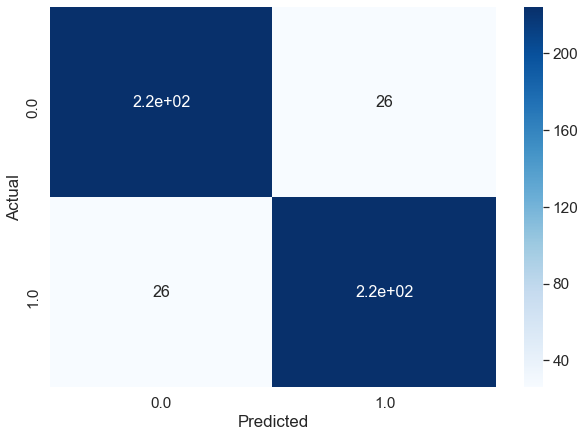

In [262]:
data = confusion_matrix(df1.iloc[:,-1], lr.predict(df1.drop(['Engagement'],axis=1)))
df_cm = pd.DataFrame(data, columns=np.unique(df1.iloc[:,-1]), index = np.unique(df1.iloc[:,-1]))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))

sn.set(font_scale=1.4)#for label size
ax = sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

### Logistic Regression with labels having high TF-IDF scores

In [246]:
df2 = pd.get_dummies(
    df_tf_labels.set_index('index').Final_Labels.str \
      .split(',\s*', expand=True).stack()
).groupby(level='index').sum().astype(int).reset_index().drop(["index"],axis=1)

df2['Engagement'] = df['Engagement']
df2

,abdomen,accessory,accipitridae,accordion,acrobatic,adansonia,adaptation,adventure,advertising,aeolian,...,working,world,worship,wrinkle,xanthorrhoeaceae,yak,yawn,yellow,youth,Engagement
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
497,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1.0
498,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


In [294]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop(['Engagement'],axis=1), df2.iloc[:,-1], test_size=0.20, random_state=42)

lr = LogisticRegression(solver = 'lbfgs')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

print("The test accuracy of the model using image labels with high TF-IDF scores is: {}".format(lr.score(X_test,y_test)))

The test accuracy of the model using image labels with high TF-IDF scores is: 0.59


(2.0, 0.0)

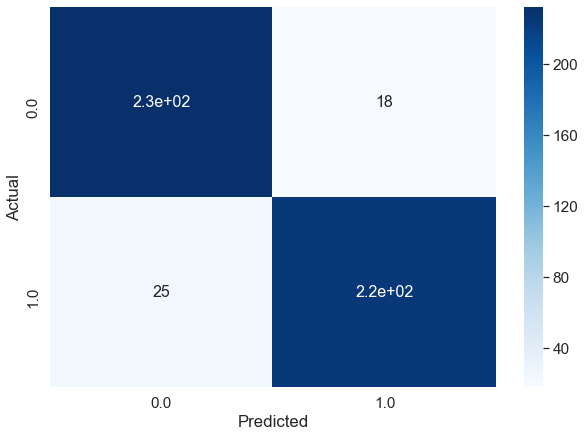

In [295]:
data = confusion_matrix(df2.iloc[:,-1], lr.predict(df2.drop(['Engagement'],axis=1)))
df_cm = pd.DataFrame(data, columns=np.unique(df2.iloc[:,-1]), index = np.unique(df2.iloc[:,-1]))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))

sn.set(font_scale=1.4)#for label size
ax = sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

### On using fewer lables identified with high TF-IDF scores, the accuracy of our model decreases. So it makes sense to use all labels for building the prediction model.

## 2. Model to predict post engagement from post captions

## Word Frequency Analysis of Captions

In [296]:
df["Caption_Tokens"] =  df["Caption"].apply(lambda x: re.findall(r"[\w']+", x.lower())[3:])
df["Caption_Tokens"] = df["Caption_Tokens"].apply(remove_stopwords)

count = []

# Count the frequency of the words
for i in range(len(df["Caption_Tokens"])):
    count += df.iloc[i]["Caption_Tokens"]

count = [x.lower() for x in count]
word_freq = nltk.FreqDist(count)

# 50 most frequent words
top_words = word_freq.most_common(500)
top_words

[('follow', 211),
 ('women', 189),
 ('world', 183),
 ('n', 157),
 ('u2063', 153),
 ('one', 148),
 ('like', 116),
 ('see', 114),
 ('life', 110),
 ('stories', 99),
 ('day', 98),
 ('images', 92),
 ('natgeo', 86),
 ('around', 86),
 ('years', 85),
 ('national', 83),
 ('year', 79),
 ('people', 77),
 ('new', 73),
 ('also', 70),
 ('photographed', 68),
 ('many', 68),
 ('wildlife', 67),
 ('part', 66),
 ('water', 66),
 ('first', 62),
 ('time', 62),
 ('next', 61),
 ('sea', 60),
 ('south', 54),
 ('two', 53),
 ('nature', 53),
 ('use', 52),
 ('story', 52),
 ('today', 52),
 ('species', 52),
 ('wild', 52),
 ('girls', 52),
 ('week', 50),
 ('city', 50),
 ('home', 49),
 ('000', 49),
 ('ocean', 48),
 ('young', 48),
 ('geo', 48),
 ('share', 48),
 ('woman', 48),
 ('across', 45),
 ('photos', 45),
 ('take', 44),
 ('family', 43),
 ('work', 43),
 ('found', 42),
 ('land', 42),
 ('long', 42),
 ('every', 42),
 ('old', 41),
 ('conservation', 41),
 ('since', 41),
 ('help', 41),
 ('island', 41),
 ('u', 40),
 ('river',

### For now we proceed with no word replacements

## Calculating TF-IDF of captions

In [297]:
df['Caption_Tokens'] = df['Caption_Tokens'].str.join(" ")

In [298]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
x = v.fit_transform(df['Caption_Tokens'].tolist())

## Selecting top 5 words from each caption that has a high TF-IDF

tf_idf = pd.DataFrame(x.toarray(), columns = v.get_feature_names()).reset_index()

df_tf_captions = tf_idf.set_index('index')
df_tf_captions = pd.DataFrame(df_tf_captions.columns.values[np.argsort(-df_tf_captions.values, axis=1)[:, :5]], 
                  index=df.index,
                  columns = ['1st Max','2nd Max','3rd Max','4th Max','5th max']).reset_index()

source_col_loc = df_tf_captions.columns.get_loc('1st Max') # column position starts from 0

df_tf_captions['final_captions'] = df_tf_captions.iloc[:,source_col_loc:source_col_loc+5].apply(
    lambda x: ",".join(x.astype(str)), axis=1)
df_tf_captions

,index,1st Max,2nd Max,3rd Max,4th Max,5th max,final_captions
0,0,charleston,hunley,submarine,restoration,sea,"charleston,hunley,submarine,restoration,sea"
1,1,outfit,cow,buckaroo,crew,williamalbertallard,"outfit,cow,buckaroo,crew,williamalbertallard"
2,2,energy,renewable,death,valley,cherished,"energy,renewable,death,valley,cherished"
3,3,mcgrew,retreat,love,massage,inkling,"mcgrew,retreat,love,massage,inkling"
4,4,gurunsi,house,ornamental,participants,tiébélé,"gurunsi,house,ornamental,participants,tiébélé"
...,...,...,...,...,...,...,...
495,495,irablockphoto,window,nowhere,upperwest,birdsofnewyork,"irablockphoto,window,nowhere,upperwest,birdsof..."
496,496,bidibidi,sudan,million,south,soda,"bidibidi,sudan,million,south,soda"
497,497,witnessing,million,sudan,planet,may,"witnessing,million,sudan,planet,may"
498,498,art,students,dissection,scrubs,drexel,"art,students,dissection,scrubs,drexel"


In [299]:
df3 = pd.get_dummies(
    df_tf_captions.set_index('index').final_captions.str \
      .split(',\s*', expand=True).stack()
).groupby(level='index').sum().astype(int).reset_index().drop(["index"],axis=1)

df3['Engagement'] = df['Engagement']
df3

,000,000ft,10,105,1666,176,18,1883,1912,1997,...,zamanbol,zayed,zealand,zebras,zimbabwe,zion,zongolopoulos,катерина,الاردن,Engagement
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


### Logistic Regression with captions having high TF-IDF scores

In [300]:
X_train, X_test, y_train, y_test = train_test_split(df3.drop(['Engagement'],axis=1), df3.iloc[:,-1], test_size=0.40, random_state=42)

lr = LogisticRegression(solver = 'lbfgs')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

print("The test accuracy of the model using image captions with high TF-IDF scores is: {}".format(lr.score(X_test,y_test)))

The test accuracy of the model using image captions with high TF-IDF scores is: 0.655


(2.0, 0.0)

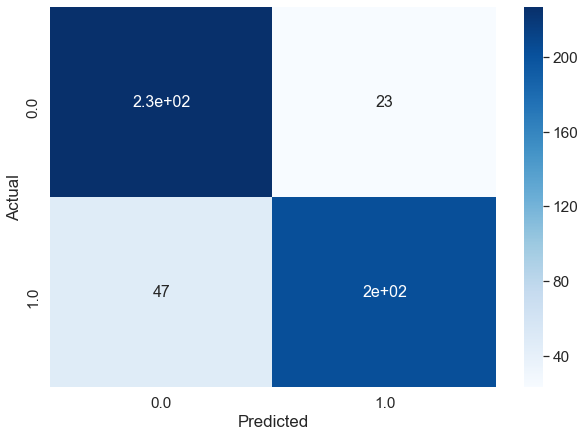

In [302]:
data = confusion_matrix(df3.iloc[:,-1], lr.predict(df3.drop(['Engagement'],axis=1)))
df_cm = pd.DataFrame(data, columns=np.unique(df3.iloc[:,-1]), index = np.unique(df3.iloc[:,-1]))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
ax = sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## 3. Model to predict post engagement using both post captions (top 5 TF-IDF in each post) and labels (all)

In [309]:
df_merged = pd.concat([df1,df3.drop('Engagement',axis=1)],axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_merged.drop(['Engagement'],axis=1),df_merged['Engagement'], test_size=0.20, random_state=42)

lr = LogisticRegression(solver = 'lbfgs')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

print("The test accuracy of the model using combination of image labels and captions is: {}".format(lr.score(X_test,y_test)))

The test accuracy of the model using combination of image labels and captions is: 0.74


(2.0, 0.0)

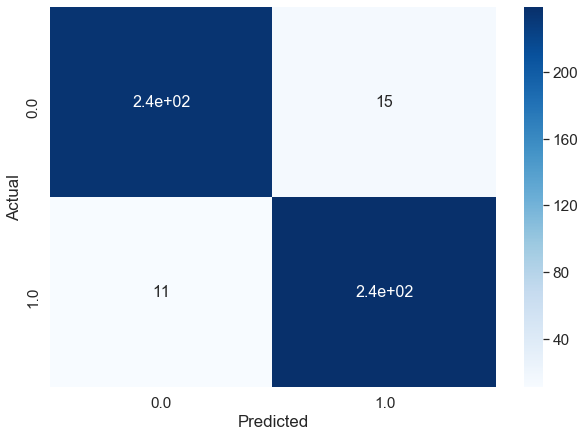

In [312]:
data = confusion_matrix(df_merged['Engagement'], lr.predict(df_merged.drop(['Engagement'],axis=1)))
df_cm = pd.DataFrame(data, columns=np.unique(df_merged['Engagement']), index = np.unique(df_merged['Engagement']))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
ax = sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

### Conclusion 
1. Using captions alone, we can predict whether the engagement of an Intagram post will be higher or lower than the median engagement score, with an accuracy of 68%
2. Using Google Vision labels, we can predict whether the engagement of an Intagram post will be higher or lower than the median engagement score, with an accuracy of 65%
3. Using both image captions and Google Vision labels, we can predict whether the engagement of an Intagram post will be higher or lower than the median engagement score, with an accuracy of 74%

## Task C

In [90]:
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [93]:
processed_labels = df['Labels'].map(preprocess)

In [120]:
processed_labels

0      [ray, skate, fish, underwat, water, manta, org...
1                                          [photographi]
2      [badland, mountain, landform, natur, mountain,...
3                [rock, tourism, landscap, nation, park]
4      [peopl, commun, yellow, tradit, event, templ, ...
                             ...                        
495    [bird, vertebr, bird, prey, beak, falcon, hawk...
496                [tree, vacat, tourism, leisur, crowd]
497    [rhinocero, horn, white, rhinocero, black, rhi...
498                    [scienc, medic, assist, research]
499    [peopl, child, adapt, sand, human, sit, soil, ...
Name: Labels, Length: 500, dtype: object

In [121]:
dictionary = gensim.corpora.Dictionary(processed_labels)
print(dictionary)

Dictionary(869 unique tokens: ['biolog', 'cartilagin', 'fish', 'manta', 'marin']...)


In [124]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 20:
        break

0 biolog
1 marin
2 organ
3 water
4 photographi
5 cloud
6 geolog
7 landform
8 mountain
9 natur
10 rock
11 landscap
12 tourism
13 adapt
14 peopl
15 smile
16 ocean
17 vacat
18 grass
19 atmospher
20 light


In [123]:
dictionary.filter_extremes(no_below=20, no_above=0.5, keep_n=100000)

In [244]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_labels]
print(bow_corpus[499])

print("\"",df['Labels'][499],"\"")
print(dictionary[13],dictionary[14],dictionary[30],dictionary[39],dictionary[42])

[(13, 1), (14, 1), (30, 1), (39, 1), (42, 1)]
" People Child Adaptation Sand Fun Human Sitting Soil Play Mud "
adapt peopl human sit child


In [136]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.6082340270761424),
 (1, 0.507001659932131),
 (2, 0.507001659932131),
 (3, 0.3405143197559628)]


In [236]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=20, id2word=dictionary, passes=2, workers=2)
df_topics=df.copy()
df_topics.drop(['URL','Caption','Label_Tokens','Like Count','Engagement Score','Engagement'], axis=1, inplace=True)
for idx, topic in lda_model.print_topics(-1):
    df_topics['Comment Count'].iloc[idx]="Topic: "+str(idx)
    df_topics['Labels'].iloc[idx]=topic


df_topics=df_topics.iloc[:20,:]
df_topics.rename(columns={'Comment Count':'Topic Name','Labels':'Words_Weights'}, inplace=True)
df_topics

,index,Topic Name,Words_Weights
0,0,Topic: 0,"0.216*""blue"" + 0.193*""water"" + 0.069*""ocean"" +..."
1,1,Topic: 1,"0.284*""marin"" + 0.144*""biolog"" + 0.114*""water""..."
2,2,Topic: 2,"0.137*""smile"" + 0.095*""adapt"" + 0.084*""leisur""..."
3,3,Topic: 3,"0.409*""mountain"" + 0.158*""landform"" + 0.065*""c..."
4,4,Topic: 4,"0.188*""vehicl"" + 0.152*""water"" + 0.126*""adapt""..."
5,5,Topic: 5,"0.243*""plant"" + 0.131*""blue"" + 0.120*""night"" +..."
6,6,Topic: 6,"0.239*""area"" + 0.125*""architectur"" + 0.069*""la..."
7,7,Topic: 7,"0.213*""tree"" + 0.090*""plant"" + 0.076*""water"" +..."
8,8,Topic: 8,"0.161*""water"" + 0.125*""natur"" + 0.094*""wildlif..."
9,9,Topic: 9,"0.201*""natur"" + 0.160*""plant"" + 0.124*""tree"" +..."


In [237]:
# Highest probability for 500th Label
count=0
for index, score in sorted(lda_model[bow_corpus[1]], key=lambda tup: -1*tup[1]):
    count+=1
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))
    if count==1:
        break


Score: 0.5249998569488525	 
Topic: 0.531*"photographi" + 0.084*"room" + 0.074*"human" + 0.053*"organ" + 0.034*"plant" + 0.029*"architectur" + 0.026*"peopl" + 0.020*"wildlif" + 0.019*"rock" + 0.019*"sit"


In [318]:
df_out.head()

,index,URL,Topic Weights,Labels
0,0,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,"0.284*""marin"" + 0.144*""biolog"" + 0.114*""water""...",Rays and skates Fish Underwater Water Manta ra...
1,1,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,"0.184*""geolog"" + 0.141*""mountain"" + 0.125*""phe...",Photography
2,2,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,"0.184*""geolog"" + 0.141*""mountain"" + 0.125*""phe...",Badlands Mountainous landforms Sky Nature Moun...
3,3,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,"0.184*""geolog"" + 0.141*""mountain"" + 0.125*""phe...",Rock Tourism Landscape National park
4,4,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,"0.184*""geolog"" + 0.141*""mountain"" + 0.125*""phe...",People Community Yellow Tradition Event Temple...


In [319]:
df_out=df.copy()
df_out.drop(['Caption','Label_Tokens','Like Count','Engagement Score','Engagement'], axis=1, inplace=True)
df_out['URL']=df['URL']
df_out['Labels']=df['Labels']
count=0

for i in range(len(df.Labels)):
    for index, score in sorted(lda_model[bow_corpus[i]], key=lambda tup: -1*tup[1]):
        count+=1
        df_out['Comment Count'].iloc[i]=lda_model.print_topic(index, 10)
        if count==1:
            break
        
df_out.rename(columns={'Comment Count':'Topic Weights'}, inplace=True)

In [320]:
df_out.to_csv("Image_TopicWeights.csv", index=False)

In [321]:
# Test label on unseen labels
unseen_document = 'fish species in the ocean'

bow_vector = dictionary.doc2bow(preprocess(unseen_document))
count=0
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    count+=1
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))
    if count==1:
        break

Score: 0.5249995589256287	 Topic: 0.191*"ocean" + 0.104*"natur" + 0.098*"horizon" + 0.095*"water" + 0.089*"cloud"


### Engagement on Topics

In [331]:
df_eng=df.copy()
df_eng.drop(['Caption','Label_Tokens'], axis=1, inplace=True)
df_eng['URL']=df['URL']
df_eng['Labels']=df['Labels']
count=0

for i in range(len(df.Labels)):
    for index, score in sorted(lda_model[bow_corpus[i]], key=lambda tup: -1*tup[1]):
        count+=1
        df_eng['Comment Count'].iloc[i]=lda_model.print_topic(index, 20)
        if count==1:
            break
        
df_eng.rename(columns={'Comment Count':'Topic Weights'}, inplace=True)

In [332]:
df_top_quartile=df_eng.sort_values('Engagement Score', ascending=False)[:125]
df_bottom_quartile=df_eng.sort_values('Engagement Score', ascending=False)[375:500]

In [513]:
ttopics={'geolog': 0, 'mountain': 0, 'phenomenon': 0, 'rock': 0, 'landform': 0, 'landscap': 0, 'tree': 0, 'water': 0,'night': 0, 'cloud': 0, 'light':0,'ocean':0,'plant':0,'atmospher':0,'area':0,'natur':0,'anim':0,'wildlif':0,'horizon':0,'grass':0,'vertebr':0,'mammal':0,'terrestri':0,'snout':0,'human':0,'adapt':0,'photographi':0,'peopl':0,'smile':0,'blue':0,'environ':0,'child':0,'green':0,'organ':0,'marin':0,'leisur':0,'biolog':0,'room':0,'architectur':0,'sit':0,'tourism':0,'sit':0,'tourism':0,'vehicl':0,'vacat':0}
btopics={'geolog': 0, 'mountain': 0, 'phenomenon': 0, 'rock': 0, 'landform': 0, 'landscap': 0, 'tree': 0, 'water': 0,'night': 0, 'cloud': 0, 'light':0,'ocean':0,'plant':0,'atmospher':0,'area':0,'natur':0,'anim':0,'wildlif':0,'horizon':0,'grass':0,'vertebr':0,'mammal':0,'terrestri':0,'snout':0,'human':0,'adapt':0,'photographi':0,'peopl':0,'smile':0,'blue':0,'environ':0,'child':0,'green':0,'organ':0,'marin':0,'leisur':0,'biolog':0,'room':0,'vacat':0,'architectur':0,'sit':0,'tourism':0,'vehicl':0}

def getDistinctTopics(topics,quartile):
    x=topics.split(" + ")
    for w in x:
        if quartile=='t':
            ttopics[w.split("*")[1].replace('"','').strip()] += float(w.split("*")[0])
        else:
            btopics[w.split("*")[1].replace('"','').strip()] += float(w.split("*")[0])
    if quartile=='t':
        return ttopics
    else:
        return btopics

In [514]:
for i in range(125):
    top_quartile_topics=getDistinctTopics(df_top_quartile["Topic Weights"].iloc[i],'t')
    bottom_quartile_topics=getDistinctTopics(df_bottom_quartile["Topic Weights"].iloc[i],'b')

In [517]:
top_quartile_topics

{'geolog': 11.392999999999992,
 'mountain': 11.197000000000001,
 'phenomenon': 8.605999999999998,
 'rock': 7.529000000000013,
 'landform': 5.8719999999999954,
 'landscap': 4.629999999999996,
 'tree': 5.152999999999999,
 'water': 5.035999999999993,
 'night': 3.494,
 'cloud': 3.2950000000000013,
 'light': 2.398,
 'ocean': 2.468000000000001,
 'plant': 3.758000000000002,
 'atmospher': 2.467999999999997,
 'area': 1.4700000000000006,
 'natur': 4.263000000000003,
 'anim': 2.3729999999999944,
 'wildlif': 3.4529999999999954,
 'horizon': 1.1899999999999982,
 'grass': 1.1690000000000003,
 'vertebr': 1.8869999999999998,
 'mammal': 2.15,
 'terrestri': 1.813,
 'snout': 1.022,
 'human': 1.818,
 'adapt': 1.2879999999999998,
 'photographi': 5.743999999999998,
 'peopl': 1.0740000000000005,
 'smile': 0.08200000000000002,
 'blue': 1.1800000000000002,
 'environ': 0.8120000000000003,
 'child': 0.34200000000000014,
 'green': 0.6240000000000002,
 'organ': 1.347,
 'marin': 1.4920000000000002,
 'leisur': 0.2960

In [516]:
bottom_quartile_topics

{'geolog': 17.47199999999998,
 'mountain': 13.736,
 'phenomenon': 12.126,
 'rock': 10.953000000000003,
 'landform': 7.491999999999987,
 'landscap': 5.120999999999994,
 'tree': 4.960000000000002,
 'water': 4.571999999999996,
 'night': 4.115000000000001,
 'cloud': 2.9810000000000003,
 'light': 2.6610000000000014,
 'ocean': 2.599000000000001,
 'plant': 3.115000000000002,
 'atmospher': 1.928000000000001,
 'area': 1.5690000000000006,
 'natur': 2.8159999999999985,
 'anim': 1.0430000000000001,
 'wildlif': 1.2529999999999992,
 'horizon': 1.1829999999999996,
 'grass': 0.9010000000000005,
 'vertebr': 0.17800000000000005,
 'mammal': 0.25,
 'terrestri': 0.1,
 'snout': 0.028,
 'human': 0.953,
 'adapt': 1.3219999999999998,
 'photographi': 1.4799999999999995,
 'peopl': 1.1149999999999998,
 'smile': 1.3820000000000001,
 'blue': 0.6360000000000001,
 'environ': 0.49100000000000005,
 'child': 0.7220000000000002,
 'green': 0.51,
 'organ': 0.45500000000000007,
 'marin': 0.732,
 'leisur': 0.961,
 'biolog': 

## Task D

### What advice would you give National Geographic if it wants to increase engagement on its Instagram page based on your findings in Tasks B and C?   

##### Intro/ Base Strategy
Based on our analysis done in Task B we realized with the correct captions alone, we can predict whether the engagement of an Intagram post will be higher or lower than the median engagement score with a decent accuracy of 68%. Thus, the caption of the post is very important in terms of overall engagedment. However when we applied Google Vision to diagnose was the least important in terms of driving engagement with an accuracy of 65%. Finally, we used the two methods in tandem, and with both image captions and Google Vision labels, we can predict whether the engagement of an Intagram post will be higher or lower than the median engagement score, with an accuracy of 74%.

In conclusion, we decided to direct National Geographic to use both metrics when deciding what to post (i.e. choose a topic with high engagement ratings, and choose an image that correlates highly with high engagement). However, you cannot select both categories at once and post about the same thing exhaustively. So, we suggest you take the top topic since the caption had the highest engagement accuracy, and run with it for a month then switch topics per month. Then, per month take that topic and post pictures with the best engagement based on Google Vision. For example, if artic animals is the top trending topic then make the next month artic animals month. And for that month, post pictures that the Google Vision believes is good for engagement ratings. We will explore a real example in the next section of the analysis. (Note: this will serve as an overall theme of say "artic month" to spur excitement, however Nat Geo doesn't need to post exclusively to the topic, but just make sure to focus on that topic as the main theme)  

##### Specific Recommendations for 2019-2020

We noticed that the two major topics in terms of TF-IDF were underwater and mountains. As per our strategy we suggest you take a topic per month and deplete it of its engagement utility posting about that topic as a main topic per month. So we suggest Januaray be "Deep Sea Life Month" as it had a relatively high TD-IDF score among all the captions. We also noticed stingray's had a very high frequency, and Google Vision predicited high engagement for stingrays. So, we suggest the first week we use stingrays posts to drive engagement! The most engaging topics will always be changing, but we will discuss this issue and how to combat it in the next section. 

##### Risks
There are certain risks involved that National Geographic must keep in mind. However, we distilled risks into two main focuses that National Geographic should keep in mind:
* These topics are ever evolving and it is very hard to stay relevant and viral.
* These metrics are at best 74% accurate.

First, the topics that engage users will always be changing. To stay on top of the trends and not fall behind, I suggest they do two things. Post "poll questions" on their instagram stories to leverage that feature of instagram as it is really quick, and users will have no reason not to fill it out as Instagram automatically feeds users the stories of accounts they follow. This will leverage the current follower base, and make sure we post things that will keep them coming back. Next, I suggest we turn to our partners at Disney+. Nat Geo is a part of the Disney+ package, if we can leverage that data to see which episodes and which shows are most popular, we may be able to attract new users to our instagram account. We could also add snippets in the corners of our episodes to bring users to our account page (i.e. during the episode show a QR code to give users a chance to see more).

Next, we have to keep in mind that these metrics don't have full-proof accuracy. Even when used in tandem, we only acheieve up to 74%, and thus we must find other methods to derive the right "Topic of the Month". I suggest that the leadership of National Geographic dedicate a new team or an arm of their analytics team to finding the next topic to choose, as well as the best pictures and videos to post. There is no clear recommendation here, but creating a team here is a good place to start.

